# 1. 힉스 데이터셋을 다운 받고 10,000개 배치를 취한 후 1,000개 샘플의 데이터 분포를 확인하시오

In [35]:
# 라이브러리 불러오기
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [8]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-5zb4rz62
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-5zb4rz62
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184144 sha256=03a87620d6181ee87492fea57c0b18263e878d0d778af9f57b1f5f3f1a619505
  Stored in directory: /tmp/pip-ephem-wheel-cache-12r33qtb/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [9]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [10]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## 힉스 데이터 세트 불러오기

In [11]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 417s 0us/step


In [12]:
# 피처의 개수는 28개이다.
FEATURES = 28

In [13]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [14]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [15]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

10000개의 배치에서 1000개 샘플의 분포를 확인한다.
- 데이터의 중심 경향이 나타난다.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


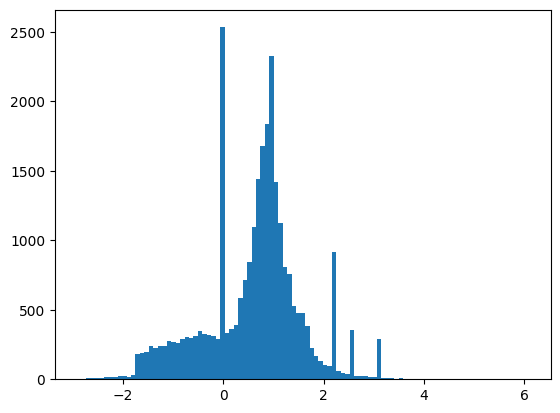

In [16]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [17]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 1000
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [23]:
print('검증용 데이터셋 : ', N_VALIDATION)
print('훈련용 데이터셋 : ', N_TRAIN)

검증용 데이터셋 :  1000
훈련용 데이터셋 :  10000


In [18]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [19]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# 2. 기준모델을 만들고 모델을 훈련하시오

tf.keras.optimizers.schedules를 통해서 시간 경과에 따라 학습률을 줄여나간다

In [20]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

시각화 된 차트를 통해 학습률의 감소를 확인할 수 있다

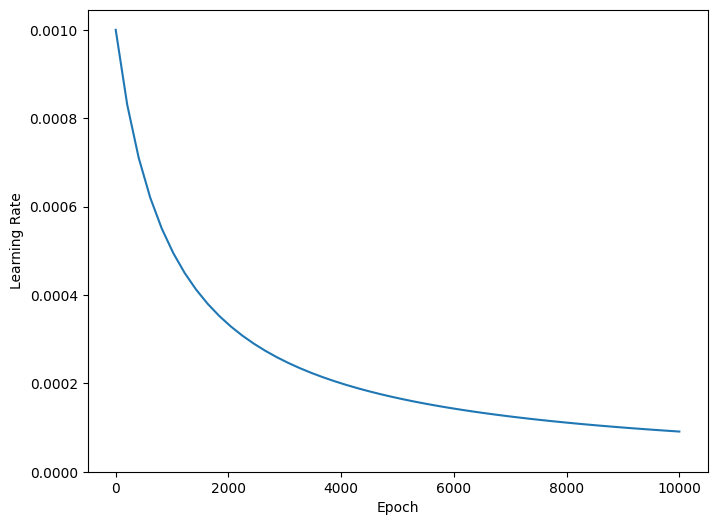

In [21]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

아래의 함수는 모델이 각 에포크를 시작할 때 훈련 진행 상황을 출력하는 역할을 하며 val_binary_crossentropy 값을 모니터링하며 지정된 조건을 충족할 때 조기 종료 기능을 제공합니다.(불필요한 훈련 시간을 줄임)

In [1]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200)
  ]

아래의 함수는 모델의 컴파일, 훈련, 및 히스토리 기록을 간편하게 수행하는 데 사용될 수 있으며, 모델 훈련 프로세스를 효율적으로 관리하는 데 사용된다.

In [2]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

# 3. 미소모델(tiny model)을 만들고 모델 훈련 결과를 시각화하시오

tiny model의 경우 뉴런의 개수가 16개이고, 레이어의 개수도 은닉층 1개, 출력층 1개, 총 2개 밖에 되지 않는 본 작업에서 사용되는 가장 작은 단위의 모델이다.
- activation function으로는 ELU 함수를 사용하였으며, 본 함수는 ReLU 형태의 함수이나 음숫값 역시 처리할 수 있는 형태이며 노이즈에 민감하지 않다는 특성을 가지고 있다.

In [22]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [23]:
size_histories = {}

In [24]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5024,  binary_crossentropy:1.0676,  loss:1.0676,  val_accuracy:0.5200,  val_binary_crossentropy:0.8908,  val_loss:0.8908,  
....................................................................................................
Epoch: 100, accuracy:0.5748,  binary_crossentropy:0.6386,  loss:0.6386,  val_accuracy:0.5590,  val_binary_crossentropy:0.6469,  val_loss:0.6469,  
............................

훈련 결과에 따르면, 정확도가 0.6858, loss가 0.5689로 나타났다. 검증 과정에서도 꾸준히 값이 감소함을 확인할 수 있었으며, 이를 통해 모델이 과대적합 없이 학습을 지속적으로 이어나가는 중임을 알 수 있었다. 마찬가지로 아래의 차트에서도 binary_crossentrophy 값에 큰 차이가 발생하지 않으며 학습이 지속되었음을 확인할 수 있다.

(0.5, 0.7)

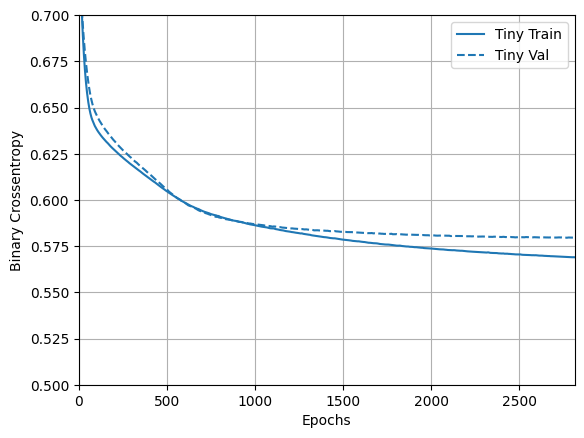

In [25]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

# 4. 뉴런 개수가 16, 64, 512인 모델을 각각 구성하고 훈련시킨 후 결과를 시각화하시오

small_model은 뉴런이 16개이다. 그러나 앞선 tiny_model에 비해 은닉층의 개수를 1개 늘렸다.

In [26]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

학습 결과 1500번째 epoch에서 정확도 0.7038, 손실 : 0.5526으로 도출되었다.

In [28]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                464       
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4893,  binary_crossentropy:0.7088,  loss:0.7088,  val_accuracy:0.4700,  val_binary_crossentropy:0.7081,  val_loss:0.7081,  
....................................................................................................
Epoch: 100, accuracy:0.6121,  binary_cros

medium_model은 뉴런이 64개이다. 또한 small_model에 비해 레이어의 개수가 1개 증가했다.

In [29]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

학습 결과 epoch 200대에서 정확도 0.7387, 손실 : 0.5035으로 도출되었다. epoch 수가 급감했으며, 정확도, 손실 측면에서 볼 경우 뉴런의 개수가 16개인 모델보다 개선되긴 하였다. 그러나 val_accuracy와 val_loss가 오히려 증가한 결과가 도출되며 모델의 과적합이 의심되기 시작한다.

In [30]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                1856      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.4824,  binary_crossentropy:0.7056,  loss:0.7056,  val_accuracy:0.4650,  val_binary_crossentropy:0.6957,  val_loss:0.6957,  
....

large_model은 뉴런이 512개이다. 또한 large_model에 비해 레이어의 개수가 1개 증가했다.

In [31]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

정확도가 1, 손실이 0.0008이라는 수치가 도출되었다. 이는 곧 모델이 훈련 데이터에 지나치게 과대적합 되었음을 의미한다. 이러한 모델의 경우 다른 데이터셋에 적용할 경우 일반화 성능이 현저히 낮을 것이며 사실상 적용이 어렵다. val_accuracy와 val_loss를 보면 값들이 급상승했으며, 이를 통해 뉴런의 개수가 512개나 될 경우 훈련 데이터에 지나친 과대적합이 발생함을 알 수 있다. 따라서 모델의 성능 개선을 위한 초기화, 정규화 등의 작업이 필요하다. 나아가 우리는 이 모델의 훈련에 하나의 배치 단위 밖에 사용하지 않았다. 천만개나 되는 데이터셋에 아주 작은 일부만 사용했기 때문에, 모델의 데이터를 늘린다면 512개의 뉴런이 적절하다는 결론이 도출될 수도 있다.

In [32]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               14848     
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

- 실선은 훈련 손실, 점선은 검증 손실을 의미함
- 적색 실선과 점선을 통해 확인할 수 있듯, 뉴런의 개수가 많은 큰 모델일 경우 오버피팅 현상이 발생할 수 있음
- tiny model을 제외하고 이외의 모델들은 epoch의 차이는 있으나 결국 모델이 오버피팅 되어 일반화가 어려워지는 현상이 발생함
- 따라서 적절한 뉴런의 개수 선정이 필요함(뉴런의 개수가 많아지는 것은 그만큼 매개변수가 많아지는 것을 의미하기도 한다)

Text(0.5, 0, 'Epochs [Log Scale]')

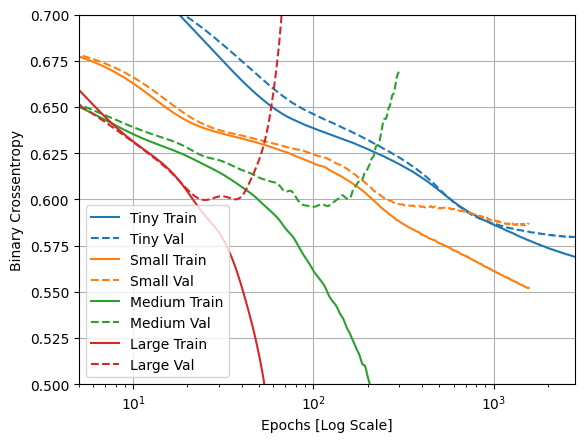

In [33]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

# 5. 가장 큰 모델 뉴런 개수 512개 에 L2 가중치 정규화를 추가하여 훈련시킨 후 결과를 시각화하시오

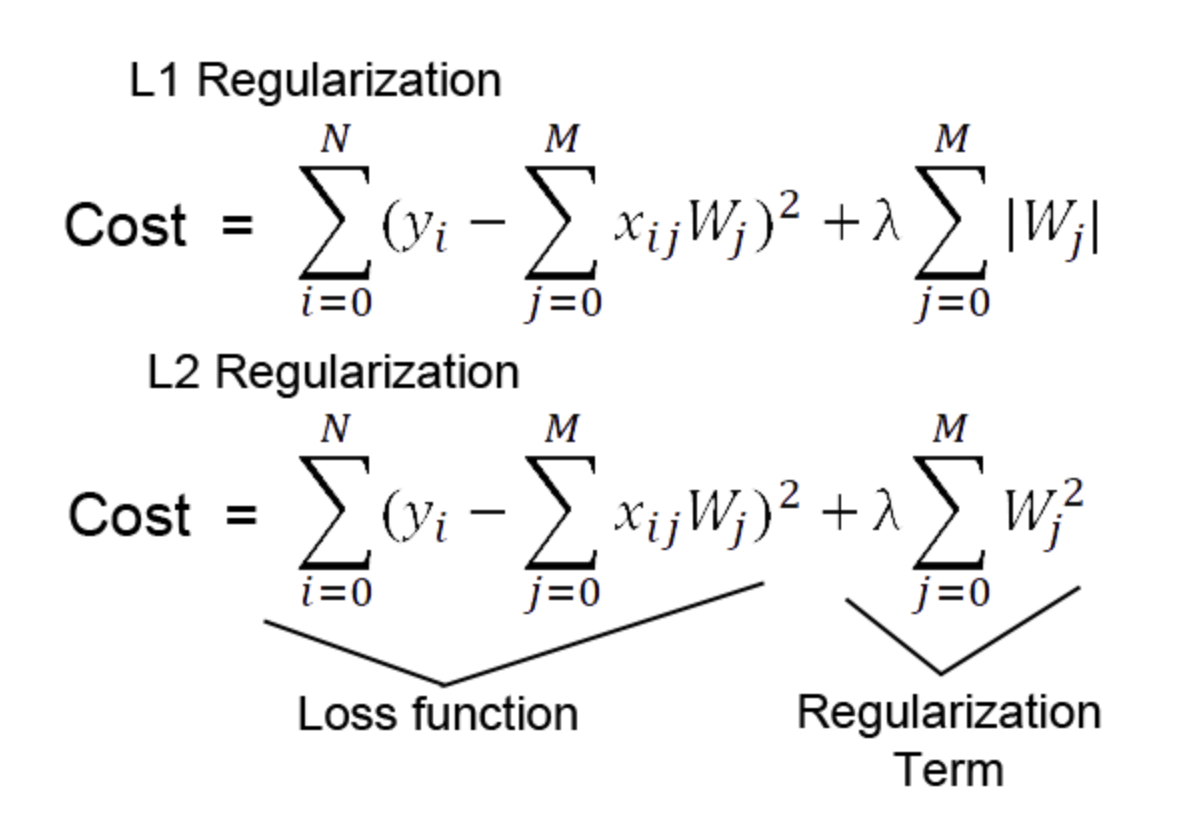

L2 정규화를 실시할 경우 가중치의 크기에 따라 페널티 정도가 달라지기 때문에, 가중치가 전반적으로 작아져 L1 정규화 대비 학습 효과가 좋아진다.

In [36]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In [37]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])
#L2 정규화 추가
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 512)               14848     
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dense_24 (Dense)            (None, 512)               262656    
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

아래의 차트와 같이 L2 정규화를 통해 모델의 성능의 개선이 뚜렷이 확인된다. 수치상으로도 훈련 데이터셋, 검증용 데이터셋 모두 정확도 값이 증가하고 손실 값이 감소했다.

(0.5, 0.7)

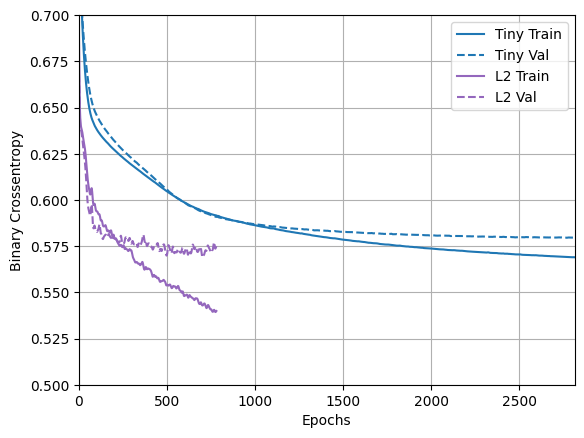

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

# 6. 드롭아웃을 추가하여 훈련시킨 후 결과를 시각화하시오

In [39]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 512)              

드롭아웃을 통해 값이 급감하긴 했으나 기존 차트와 비교해볼 경우, 성능의 개선을 보인다.

(0.5, 0.7)

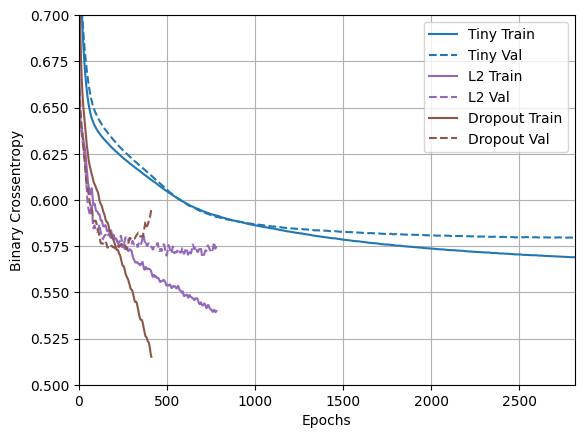

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

# 7. L2 + 드롭아웃 결합 후 훈련시키고 결과를 시각화하시오

In [41]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_35 (Dense)            (None, 512)              

아래의 차트를 통해 결합된 모델의 성능이 가장 준수함을 확인할 수 있다.

(0.5, 0.7)

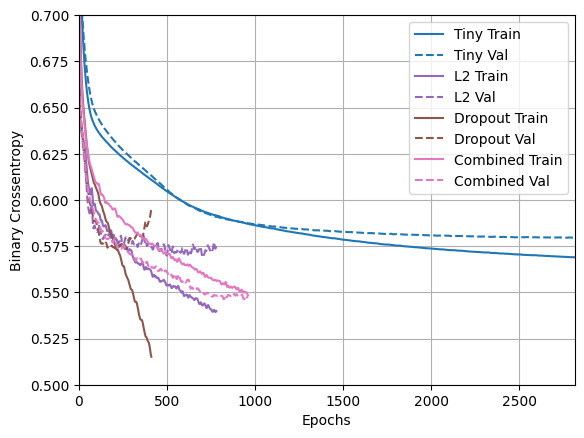

In [42]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

# 8. 본 문제를 통해 얻을 수 있는 결론을 서술하시오

본 문제를 통해 우리는 교과서 기준 5장에 해당하는 '초기화와 정규화' 챕터의 내용에 대해 학습하였다. 모델을 개발할 때 무엇보다 중요한 것은 과대적합을 방지하고 일반화 성능을 높이는 것인데, 본 문제를 통해 좋은 모델을 만드는 방법에 대해 학습했다. 뉴런의 개수를 16개, 64개, 512개로 늘려가며 모델이 오버피팅 되는 현상을 직접 확인했다. 이는 네트워크 용량을 줄일 경우 일반화 성능을 개선할 수 있음을 의미한다. 이후 가중치 정규화(본 문제에서는 L2 정규화 사용)를 통해 가중치 감쇠를 유도했고, 해당 정규화 항을 통해 모델의 복잡도를 감소시켰다. 물론 오버피팅을 해결하기 위해서 가장 좋은 방법은 의미 있는 데이터를 늘리는 것이지만 이는 현실적으로 쉬운 문제는 아니다. 따라서 이를 해결하기 위해 드롭아웃 기법을 활용하여 추가 데이터 없이 기존의 데이터로 성능을 개선하고 파라미터의 복잡도를 줄이는 방향으로 512개나 되는 large_model의 뉴런을 on, off하며 성능을 개선하였다. 최종적으로 L2 정규화와 드롭아웃을 함께 사용한 combined_model을 통해 모든 오버피팅 문제가 해결되었음을 확인할 수는 없었으나, 성능의 개선이 시각화 된 차트를 통해 확연하게 드러났다.

# 문제 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

#1. 데이터셋을 다운 받고 클래스의 개수를 확인하시오

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

데이터셋의 클래스의 개수는 5개다.

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


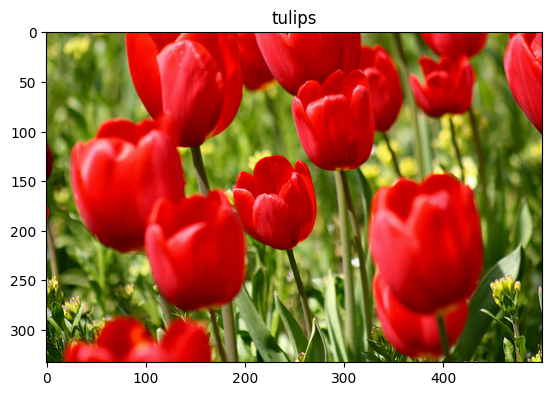

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

# 2. 크기 및 배율을 조정하시오

- 데이터 증강은 훈련 데이터셋을 이용해서 새로운 데이터를 생성하는 기법으로, 데이터를 수집하여 큰 데이터셋을 만드는 것보다 기존 데이터셋을 활용하여 데이터를 보다 쉽게 늘려주는 방법이다. 따라서 아래에서는 이미지의 크기와 배율을 조절하여 데이터 증강을 꾀한다.

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

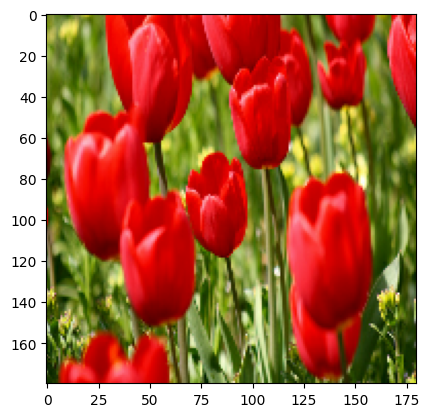

In [ ]:
# resize, rescale 작업을 진행하였다. 육안으로도 튤립 사진이 작아진 것을 확인할 수 있다.
result = resize_and_rescale(image)
_ = plt.imshow(result)

앞서 레이어를 rescale해준 덕분에 픽셀의 최소값과 최대값이 0~1 범주 사이에 위치한다.

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


# 3. 데이터 증강을 수행하고 시각화하시오

이전 수업 시간에서 이미지를 회전시킨다거나, 뒤집는 등의 방법을 통해 데이터를 증강하는 방법에 대해 배웠었는데, 아래의 두 메소드를 통해 해당 기법을 실천할 수 있다.
- tf.keras.layers.RandomZoom : 이미지를 무작위로 확대하는 변환을 적용시켜 데이터를 증강하는 기법
- tf.keras.layers.RandomContrast : 이미지의 대비를 무작위로 조절하여 이미지의 밝기 대비를 변화시켜 데이터를 증강하는 기법
- tf.keras.layers.RandomCrop : 이미지에서 무작위 부분을 잘라내어 크기를 줄이거나 특정 객체나 특징에 집중하도록 하여 데이터를 증강하는 기법

이외에도 다양한 기법이 존재한다.
- 이미지 회전 (Random Rotation): 이미지를 무작위로 회전시켜 다양한 각도에서 이미지를 학습함
- 이미지 뒤집기 (Random Flip): 이미지를 수평 및 수직으로 무작위로 뒤집어서 좌우 대칭 및 상하 대칭 이미지를 생성함
- 이미지 이동 (Random Shift): 이미지를 무작위로 이동시켜서 객체의 위치 변화를 모델에 학습시킴
- 이미지 밝기 조정 (Random Brightness): 이미지의 밝기를 조절하여 다양한 조명 조건에서 학습함
- 이미지 가우시안 노이즈 추가 (Random Noise): 이미지에 작은 가우시안 노이즈를 추가하여 모델이 노이즈에 견딜 수 있는 더 강건한 모델을 빌드함
- 이미지 컷아웃 (Cutout): 이미지 일부를 임의로 가리는 것으로, 모델이 일부 영역에 대한 정보 부족을 보완하고 로버스트한 특징을 학습함
- 컬러 조정 (Color Jittering): 이미지의 채도, 명도, 대비 등을 무작위로 조정하여 다양한 색상과 환경에서 학습함
- 이미지 스케일링 (Random Scaling): 이미지 크기를 무작위로 조절하여 다양한 크기의 객체를 인식할 수 있도록 모델을 학습함

In [ ]:
# 데이터 증강을 위해 뒤집기와 회전 레이어를 설정함
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# 이미지를 모델에 입력할 수 있도록 미니배치로 확장함
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

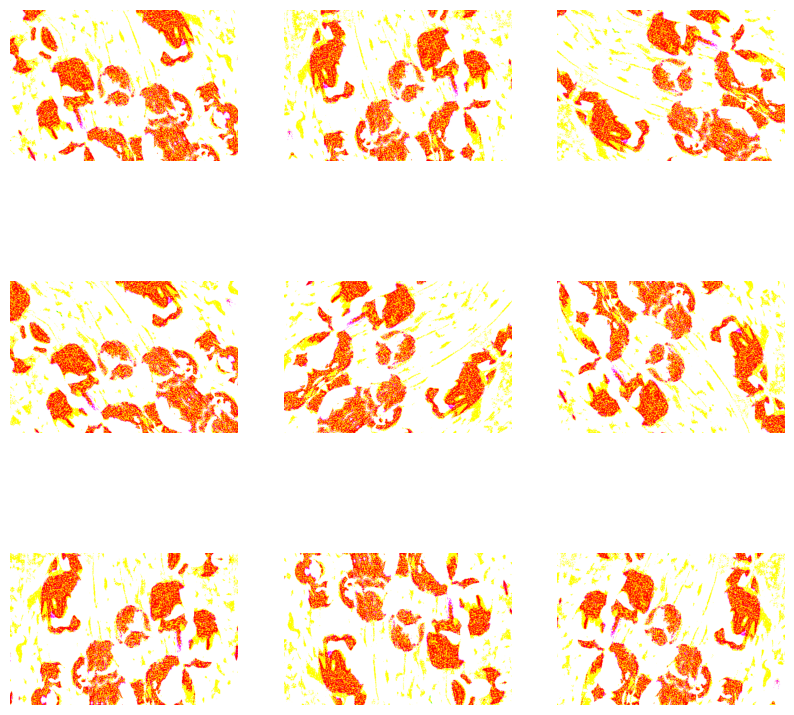

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# 4. 두 가지 옵션을 사용하여 Keras 전처리 레이어를 사용하시오

## 옵션 1: 전처리 레이어를 모델의 일부로 만들기
- 데이터 증강을 모델에 포함시키는 것을 의미
- 데이터 증강 레이어를 모델의 첫 레이어로 적용시킴
- 모델 구조를 정의할 때 이미지 데이터 전처리를 함께 정의하는 기법

In [ ]:
model = tf.keras.Sequential([
  resize_and_rescale,
  # 데이터 증강 수행
  data_augmentation,
  # CNN 레이어 정의, 각 레이어는 3*3 합성곱 연산 수행, padding은 입력과 출력의 크기를 동일하게 유지하게 하며, 활성화 함수는 relu함수임
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 맥스풀링은 입력 데이터의 공간 차원을 줄이는 역할을 수행하며, 주로 CNN 레이어 이후에 사용됨
  layers.MaxPooling2D()
])

## 옵션 2: 데이터세트에 전처리 레이어 적용하기
- 데이터 증강을 데이터 로딩 과정에서 적용하는 기법
- 데이터를 로드한 후 바로 데이터세트에 전처리 함수 또는 레이어를 적용하여 이미지 데이터를 변환함
- 이와 같은 방법을 사용할 경우 데이터셋에 여러 번 적용할 수 있으며, 원본 데이터가 변경되지 않습니다.

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

# 5. 데이터셋에 전처리 레이어를 적용하시오. 참고: 데이터 증강은 훈련셋에만 적용

In [ ]:
# 하나의 배치 사이즈는 32
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # 모든 데이터셋의 크기와 배율을 조절함
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # 데이터를 섞어줌
  if shuffle:
    ds = ds.shuffle(1000)

  # 데이터 세트를 배치 단위로 분할함
  ds = ds.batch(batch_size)

  # 데이터 증강은 훈련 데이터셋에만 실시한다.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # .prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹친다.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# prepare는 데이터를 증강하고 전처리하는 메소드
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# 6. 모델을 훈련하고 정확도에 대해 평가하시오

In [ ]:
model = tf.keras.Sequential([
  # 첫 번째 CNN 레이어를 정의, 16개의 필터를 사용하며 3*3 합성곱 연산을 수행, 입력과 출력의 크기를 동일하게 유지하며 활성화 함수는 ReLU
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 맥스풀링은 주로 CNN 레이어 뒤에 위치함 / 입력 데이터의 공간 차원을 줄이는 역할을 수행
  layers.MaxPooling2D(),
  # 두 번째 CNN 레이어를 정의, 32개의 필터를 사용하며 3*3 합성곱 연산을 수행, 입력과 출력의 크기를 동일하게 유지하며 활성화 함수는 ReLU
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  # 맥스풀링은 주로 CNN 레이어 뒤에 위치함 / 입력 데이터의 공간 차원을 줄이는 역할을 수행
  layers.MaxPooling2D(),
  # 세 번째 CNN 레이어를 정의, 64개의 필터를 사용하며 3*3 합성곱 연산을 수행, 입력과 출력의 크기를 동일하게 유지하며 활성화 함수는 ReLU
  # 이미지의 다양한 특징을 추출하고, 다운샘플링하여 모델의 복잡도를 줄여주고 있음
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  # 맥스풀링은 주로 CNN 레이어 뒤에 위치함 / 입력 데이터의 공간 차원을 줄이는 역할을 수행
  layers.MaxPooling2D(),
  # 2D 텐서를 1D 텐서로 평평하게 펴줍니다. 이는 CNN에서 추출된 특징을 Fully connected Layer에 전달할 때 사용됨
  layers.Flatten(),
  # 128개의 뉴런을 가진 Fully connected Layer에 전달함
  layers.Dense(128, activation='relu'),
  # 출력 레이어를 정의했으며, 뉴런의 개수는 클래스의 개수로 맞춤
  layers.Dense(num_classes)
])

In [ ]:
# 모델을 아래와 같은 변수들로 컴파일함
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# epoch는 5이며 컴파일된 모델을 학습시킴
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
92/92 [==============================] - 138s 1s/step - loss: 1.3697 - accuracy: 0.4019 - val_loss: 1.2512 - val_accuracy: 0.4360
Epoch 2/5
92/92 [==============================] - 137s 1s/step - loss: 1.0878 - accuracy: 0.5528 - val_loss: 0.9967 - val_accuracy: 0.6213
Epoch 3/5
92/92 [==============================] - 123s 1s/step - loss: 0.9680 - accuracy: 0.6052 - val_loss: 0.8857 - val_accuracy: 0.6730
Epoch 4/5
92/92 [==============================] - 144s 2s/step - loss: 0.8978 - accuracy: 0.6366 - val_loss: 0.8408 - val_accuracy: 0.6730
Epoch 5/5
92/92 [==============================] - 133s 1s/step - loss: 0.8560 - accuracy: 0.6662 - val_loss: 0.9936 - val_accuracy: 0.6349


훈련 데이터셋에서는 0.8560의 손실, 0.6662의 정확도 값이 도출되었으며, 테스트 데이터셋에서는 0.9551의 손실, 0.6131의 정확도 값이 도출됨

In [ ]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

12/12 [==============================] - 4s 289ms/step - loss: 0.9551 - accuracy: 0.6131
Accuracy 0.6130790114402771
